# Analyse et Visualisation des R√©sultats de Clustering - Projet GEMINI

Ce notebook a pour objectif de **traiter, d'analyser et de visualiser les r√©sultats de classification spectrale** obtenus par l'algorithme GEMINI (MLP-MMD) sur les spectres de galaxies.  
Les r√©sultats analys√©s ici ont √©t√© **g√©n√©r√©s √† l'aide de scripts d'ex√©cution et de tests** ex√©cut√©s sur des machines de calcul √† distance, et sont disponibles sur [mon GitHub](https://github.com/RacimZz/Gemclus_DeepLearning).

---

## Contexte

Dans le cadre du projet, plusieurs exp√©riences de classification non supervis√©e ont √©t√© men√©es afin d'explorer diff√©rentes configurations d'hyperparam√®tres (nombre de clusters, kernel, learning rate, etc.).  
Les donn√©es brutes ainsi que les r√©sultats interm√©diaires (labels de clusters, m√©triques d'√©valuation) sont syst√©matiquement sauvegard√©s pour permettre une analyse d√©taill√©e.

---

## Objectifs de ce notebook

- Charger et agr√©ger les r√©sultats de clustering (labels, scores, etc.).
- Traiter le contenus des JSON(l) g√©ner√©s sur le serveur.
- Calculer des m√©triques d'√©valuation de la qualit√© de classification (Silhouette, Calinski-Harabasz, Davies-Bouldin‚Ä¶).
- Visualiser les partitions obtenues (courbes, diagrammes de Sankey, visualisation 3D).
- Comparer diff√©rentes configurations de mod√®les et d'hyperparam√®tres.
- G√©n√©rer des graphiques pour les rapports ou pr√©sentations.

---

## Note technique

Les r√©sultats charg√©s ici ont √©t√© g√©n√©r√©s en amont par des scripts Python/R (voir le d√©p√¥t GitHub), lanc√©s sur des clusters de calcul distants. Ce notebook **n'entra√Æne pas de mod√®les**, il se concentre uniquement sur l'analyse et la valorisation des r√©sultats.

---


### Import des biblioth√®ques
Importation des librairies n√©cessaires pour l'analyse, le calcul et la visualisation des donn√©es spectrales et des r√©sultats de clustering.

In [2]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import adjusted_rand_score, silhouette_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
import plotly.graph_objects as go
import plotly.io as pio

from sklearn.preprocessing import StandardScaler
from gemclus import mlp
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score


### Calculs du silhouette score de la classification de [Chambon et Al.]
On calcule le silhouette score de la classification avec FisherEM pour pouvoir comparer avec nos r√©sultats en Deep Learning.

In [ ]:

# Charger les donn√©es 
X = pd.read_csv("../DATA/flux_pretreated_NGC1068_6400_6800_high_velocity_normalise_redshift_filter_subset-002.csv", header=None).to_numpy()  
# Charger les labels ()
labels_df = pd.read_csv("../DATA/classification_results_K16_DkBk_NGC1068_6400_6800_high_velocity_normalise_subset_redshift_filter_it25_25.csv", header=None).to_numpy()  
labels = labels_df[:, 1]  # deuxi√®me colonne (index 1) contient les labels

# V√©rification du nombre de clusters
if len(set(labels)) < 2:
    print("‚ùå Impossible de calculer le score : un seul cluster d√©tect√©.")
else:
    score = silhouette_score(X, labels)
    print(f"‚úÖ Silhouette Score : {score:.4f}")


### Chargement d'une autre version des donn√©es spectrales
Test de chargement d'une version normalis√©e, pour comparer diff√©rents traitements.

In [17]:
X = pd.read_csv("../DATA/flux_pretreated_NGC1068_6400_6800_high_velocity_normalise_redshift_filter_subset-002.csv",delimiter=",").to_numpy()  
print(f"{X.shape[0]} spectres et {X.shape[1]} points de donn√©es par spectre")

68232 spectres et 3592 points de donn√©es par spectre


### Chargement des labels de classification
On charge les r√©sultats de classification g√©n√©r√©s pr√©c√©demment (labels de clusters trouv√©s).

In [38]:
labels_df = pd.read_csv("../labels_sample68232_clusters30_kernellinear_lr0.001_hid20_standardise_.csv", header=None)  # reste en DataFrame
print(f"{labels_df.shape[0]} spectres et {labels_df.shape[1]} colonnes dans le DataFrame des labels")

68232 spectres et 2 colonnes dans le DataFrame des labels


### Chargement des donn√©es brutes
Pour comparaison ou analyses compl√©mentaires, on charge les donn√©es spectrales brutes (avant tout pr√©traitement).

In [42]:

# Chargement des donn√©es brutes
X_raw = pd.read_csv("../DATA/flux_pretreated_NGC1068_6400_6800_high_velocity_normalise_redshift_filter_subset-002.csv", delimiter=",").to_numpy()
print("‚úÖ Donn√©es brutes charg√©es :", X_raw.shape)

# Normalisation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_raw)
print("‚úÖ Donn√©es normalis√©es :", X_scaled.shape)

# Chargement du fichier de labels (avec indices)
labels_df = pd.read_csv("../labels_sample68232_clusters30_kernellinear_lr0.001_hid20_standardise_.csv")
print(f"‚úÖ {labels_df.shape[0]} lignes de labels charg√©es")

# R√©cup√©rer les indices et les labels
indices = labels_df["index"].to_numpy()
labels = labels_df["cluster"].to_numpy()

# Restreindre X aux bons indices
X_sub = X_scaled[indices]

# V√©rification du nombre de clusters
if len(set(labels)) < 2:
    print("‚ùå Impossible de calculer le score : un seul cluster d√©tect√©.")
else:
    score = silhouette_score(X_sub, labels)
    print(f"‚úÖ Silhouette Score : {score:.4f}")

‚úÖ Donn√©es brutes charg√©es : (68232, 3592)
‚úÖ Donn√©es normalis√©es : (68232, 3592)
‚úÖ 68232 lignes de labels charg√©es
‚úÖ Silhouette Score : -0.0630


### Calcul des scores de clustering
On calcule deux scores d'√©valuation de la qualit√© du clustering : Calinski-Harabasz et Davies-Bouldin.

In [22]:
ch_score = calinski_harabasz_score(X, labels) if len(set(labels)) > 1 else np.nan
db_score = davies_bouldin_score(X, labels) if len(set(labels)) > 1 else np.nan


### Affichage des scores de clustering
On affiche les valeurs des scores pr√©c√©demment calcul√©s.

In [23]:
print("calinski_harabasz_score:", ch_score)
print("davies_bouldin_score:", db_score)

calinski_harabasz_score: 569.3176222537004
davies_bouldin_score: 65.27250244732797


### Import d'une fonction personnalis√©e (ou utilitaire) pour le clustering
On importe ou adapte une fonction sp√©cifique pour l'analyse ou le post-traitement des clusters.

Pour n_clusters = 21 le score silhouette moyen est : -0.06301214804573006


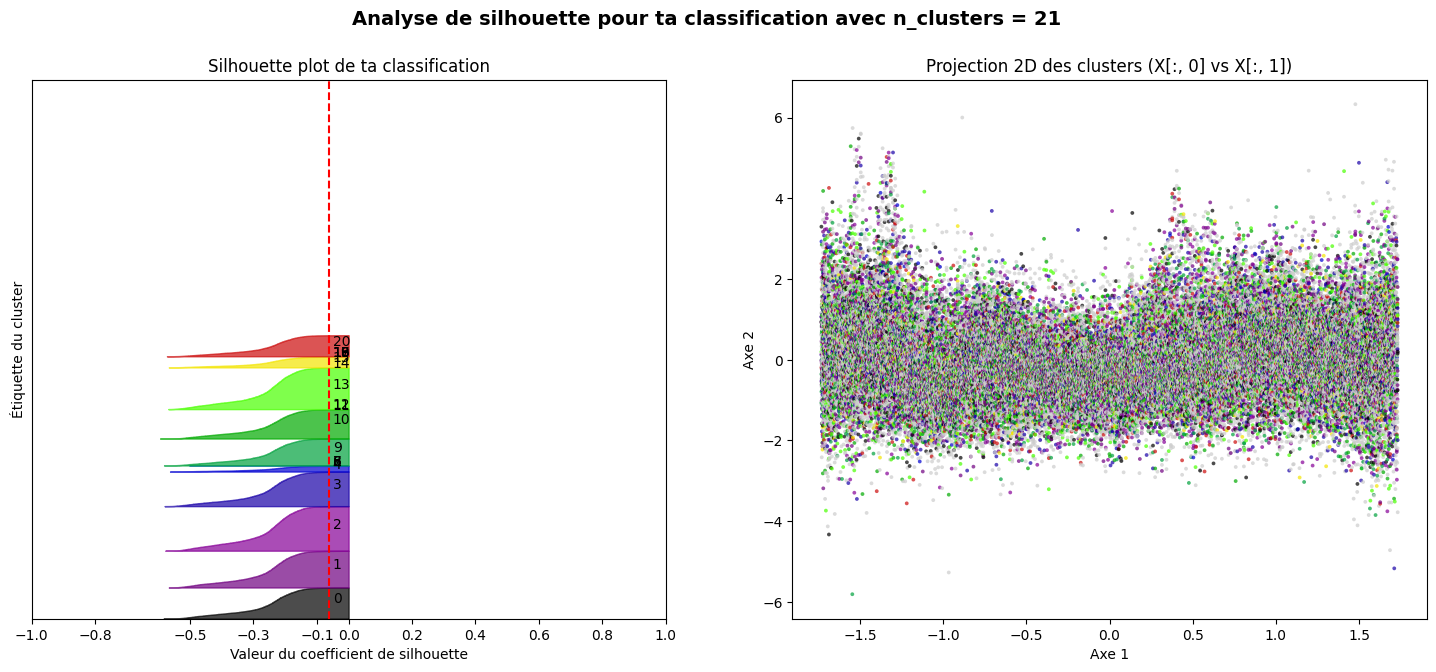

In [43]:
# SPDX-License-Identifier: BSD-3-Clause
# Auteurs : scikit-learn devs + adapt√© pour ton cas

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import silhouette_samples, silhouette_score



# D√©terminer le nombre de clusters uniques
range_n_clusters = [len(np.unique(labels))]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Pas de fit_predict ici, on utilise directement les labels
    cluster_labels = labels

    # Silhouette moyenne globale
    silhouette_avg = score
    print(
        "Pour n_clusters =",
        n_clusters,
        "le score silhouette moyen est :",
        silhouette_avg,
    )

    # Score pour chaque point
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10  # espacement entre clusters

    ax1.set_title("Silhouette plot de ta classification")
    ax1.set_xlabel("Valeur du coefficient de silhouette")
    ax1.set_ylabel("√âtiquette du cluster")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])
    ax1.set_xticks([-1,-0.8,-0.5,-0.3,-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot: projection des clusters en 2D (juste pour visuel)
    # ATTENTION : ici on suppose que X est au moins 2D
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    ax2.set_title("Projection 2D des clusters (X[:, 0] vs X[:, 1])")
    ax2.set_xlabel("Axe 1")
    ax2.set_ylabel("Axe 2")

    plt.suptitle(
        "Analyse de silhouette pour ta classification avec n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()


### (Double) Chargement et normalisation des donn√©es (optionnel)
Chargement r√©p√©t√© pour v√©rification ou autres tests sur les donn√©es spectrales.

In [29]:
# Chargement et normalisation des donn√©es
X_raw = pd.read_csv("../DATA/flux_pretreated_NGC1068_6400_6800_high_velocity_normalise_redshift_filter_subset-002.csv", delimiter=",").to_numpy()
print("‚úÖ Donn√©es brutes charg√©es :", X_raw.shape)

# Normalisation des donn√©es
scaler = StandardScaler()
X = scaler.fit_transform(X_raw)
print("‚úÖ Donn√©es normalis√©es :", X.shape)

labels_df = pd.read_csv("../DATA/classification_results_K16_DkBk_NGC1068_6400_6800_high_velocity_normalise_subset_redshift_filter_it25_25.csv", header=None)  # reste en DataFrame
print(f"{labels_df.shape[0]} spectres et {labels_df.shape[1]} colonnes dans le DataFrame des labels")

labels = labels_df[1].to_numpy()  # colonne 1 = labels
# V√©rification du nombre de clusters
if len(set(labels)) < 2:
    print("‚ùå Impossible de calculer le score : un seul cluster d√©tect√©.")
else:
    score = silhouette_score(X, labels)
    print(f"‚úÖ Silhouette Score : {score:.4f}")


‚úÖ Donn√©es brutes charg√©es : (68232, 3592)
‚úÖ Donn√©es normalis√©es : (68232, 3592)
68232 spectres et 2 colonnes dans le DataFrame des labels
‚úÖ Silhouette Score : -0.0816


### D√©finition des hyperparam√®tres de tests
On pr√©pare diff√©rentes valeurs de kernels, nombres de clusters et learning rates √† tester sur Gemini.

In [ ]:
# D√©finir les param√®tres de test
kernels = ["linear", "poly"]
n_clusters_list = [20,30,40]
LR = [1e-2, 1e-3, 1e-4]
results = []

### Choix manuel d'une combinaison d'hyperparam√®tres √† tester
Ici, kernel = 'poly', nombre de clusters = 30, lr = 0.001.

In [29]:
kernel = "poly"
n_clusters = 30
lr = 0.001
print("************************************************************************")
print(f"‚è≥ Test : n_clusters={n_clusters}, kernel={kernel}, learning_rate={lr}")
start = time.time()
model = mlp.MLPMMD(n_clusters=n_clusters, kernel=kernel, random_state=0, ovo=True, max_iter=15)
y_pred = model.fit_predict(X)
duration = time.time() - start

try:
    n_labels = len(set(y_pred))
    sil_score = silhouette_score(X, y_pred) if n_labels > 1 else np.nan
    ch_score = calinski_harabasz_score(X, y_pred) if n_labels > 1 else np.nan
    db_score = davies_bouldin_score(X, y_pred) if n_labels > 1 else np.nan
except Exception:
    sil_score = ch_score = db_score = np.nan

results.append({
    "kernel": kernel,
    "n_clusters": n_clusters,
    "n_labels": n_labels,
    "time": duration,
    "silhouette": sil_score,
    "calinski_harabasz": ch_score,
    "davies_bouldin": db_score,
    "learning_rate": 0.001,
    "score": model.score(X),
    "ovo": True,
    "n_iter": model.n_iter_
})

print(f"‚úÖ Fini :")
print(f"time = {duration:.2f}s, nombre de labels = {n_labels}, silhouette = {sil_score}")
print(f"Calinski-Harabasz: {ch_score}, Davies-Bouldin: {db_score}")
print(f"Score du modele : {model.score(X)} en {model.n_iter_} it√©rations")
print("************************************************************************")

print()

************************************************************************
‚è≥ Test : n_clusters=30, kernel=poly, learning_rate=0.001


AttributeError: 'MLPMMD' object has no attribute '_validate_data'

### Import de librairies pour la visualisation Sankey et encodage
On pr√©pare les outils pour cr√©er des graphes Sankey comparant diff√©rentes classifications.

In [17]:
import pandas as pd
import plotly.graph_objects as go
from sklearn.preprocessing import LabelEncoder
import plotly.io as pio

def plot_sankey(labels_old, labels_new, title="Sankey: ancienne vs nouvelle classification"):
    # Affichage dans le navigateur
    pio.renderers.default = "browser"

    assert len(labels_old) == len(labels_new), "Les deux vecteurs doivent avoir la m√™me taille"

    # Encoder pour avoir des entiers cons√©cutifs
    le_old = LabelEncoder().fit(labels_old)
    le_new = LabelEncoder().fit(labels_new)
    old_encoded = le_old.transform(labels_old)
    new_encoded = le_new.transform(labels_new)

    # Cr√©er un DataFrame crois√©
    df = pd.DataFrame({"old": old_encoded, "new": new_encoded})
    flow = df.groupby(["old", "new"]).size().reset_index(name='count')

    # Cr√©er les labels pour le sankey
    old_labels = [f"Old {cls}" for cls in le_old.classes_]
    new_labels = [f"New {cls}" for cls in le_new.classes_]
    labels = old_labels + new_labels

    # Mapper les index
    flow['source'] = flow['old']
    flow['target'] = flow['new'] + len(le_old.classes_)

    # Sankey diagram avec gros pad et grande hauteur
    fig = go.Figure(data=[go.Sankey(
        node=dict(
            pad=120,             # Tr√®s grand espace entre les classes
            thickness=20,
            line=dict(color="black", width=0.5),
            label=labels
        ),
        link=dict(
            source=flow['source'],
            target=flow['target'],
            value=flow['count']
        )
    )])

    fig.update_layout(
        title_text=title,
        font_size=12,
        height=4000           # Hauteur augment√©e pour scroller
    )
    # fig.show()   # <-- tu peux commenter si tu ne veux plus afficher dans le browser
    return fig

# Chargement des classifications
classification_old = pd.read_csv(
    "../nameclass_standardise.csv",
    header=None
).to_numpy()
print("Classification ancienne charg√©e :", classification_old.shape)

class_old = []
for i in classification_old:
    if len(i) > 1:
        class_old.append(i[1])
    else:
        class_old.append(i[0])

classification_new = pd.read_csv(
    "../spectra4567fclsK87.csv", header=None
).to_numpy()
print("Classification nouvelle charg√©e :", classification_new.shape)

class_new = []
for i in classification_new:
    if len(i) > 1:
        class_new.append(i[1])
    else:
        class_new.append(i[0])

fig = plot_sankey(class_old, class_new, title="Sankey Diagram")



Classification ancienne charg√©e : (302248, 2)
Classification nouvelle charg√©e : (302248, 2)


### Chargement d'un fichier RData (spectres)
Utilisation de pyreadr pour lire des fichiers de donn√©es R, par exemple des spectres sauvegard√©s via R.

In [2]:
import pyreadr
import pandas as pd
import os

# Chemin vers ton .RData
rdata_path = '../spectra4567fclsK87.RData'  # √Ä adapter !
output_dir = '../'  # Dossier o√π tu veux stocker les CSV

# Cr√©e le dossier de sortie si besoin
os.makedirs(output_dir, exist_ok=True)

# Charge le .RData
result = pyreadr.read_r(rdata_path)

# Pour chaque objet extrait, on essaie de l'exporter en CSV
for key in result.keys():
    print(f"Traitement de {key}...")
    obj = result[key]
    # Si c'est un DataFrame
    if isinstance(obj, pd.DataFrame):
        obj.to_csv(f"{output_dir}/{key}.csv", index=False)
    # Si c'est un vecteur/array
    elif isinstance(obj, (pd.Series, list)):
        pd.DataFrame(obj).to_csv(f"{output_dir}/{key}.csv", index=False, header=False)
    # Pour les autres objets simples (exemple¬†: un int, float...)
    else:
        try:
            pd.DataFrame([obj]).to_csv(f"{output_dir}/{key}.csv", index=False, header=False)
        except Exception as e:
            print(f"Non export√©¬†: {key} ({type(obj)}) ‚Äî {e}")

print("Conversion termin√©e¬†! Les fichiers sont dans", output_dir)


Traitement de spectra4567fclsK87...
Conversion termin√©e¬†! Les fichiers sont dans ../


### Export d'une figure Plotly en image PNG
Sauvegarde d'une visualisation Plotly (ex: Sankey) en fichier image.

In [19]:
# Apr√®s fig.update_layout(...)
fig.write_image("../newplot.png.png", width=1600, height=4000, scale=2, engine="kaleido")  # Image tr√®s grande

# --- G√©n√©rer un PDF avec cette image (optionnel) ---
from reportlab.platypus import SimpleDocTemplate, Image as RLImage
from reportlab.lib.pagesizes import A0  # Peut aussi essayer A1, etc. selon la taille

pdf_path = "sankey_diagram.pdf"
doc = SimpleDocTemplate(pdf_path, pagesize=A0)
story = [RLImage("sankey.png", width=1500, height=3800)]  # Ajuste width/height si besoin
doc.build(story)

print("PDF export√© !")


ValueError: 
Image export using the "kaleido" engine requires the Kaleido package,
which can be installed using pip:

    $ pip install --upgrade kaleido


### Lecture d'un fichier CSV de r√©sultats de clustering
On charge une classification pr√©c√©dente pour analyse ou comparaison.

In [8]:
import pandas as pd

df = pd.read_csv("../spectra4567fclsK87.csv", header=None)

# Ajouter l'indice √† gauche (de 1 √† N)
df.insert(0, None, range(1, len(df) + 1))

# Sauvegarder SANS ent√™te de colonne
df.to_csv("../spectra4567fclsK87_avec_index.csv", index=False, header=False)


[[1, 29], [2, 11], [3, 29], [4, 29], [5, 29], [6, 11], [7, 4], [8, 29], [9, 29], [10, 29], [11, 4], [12, 2], [13, 29], [14, 29], [15, 4], [16, 4], [17, 4], [18, 29], [19, 2], [20, 4], [21, 4], [22, 4], [23, 11], [24, 11], [25, 11], [26, 11], [27, 11], [28, 11], [29, 29], [30, 29], [31, 29], [32, 4], [33, 4], [34, 4], [35, 4], [36, 4], [37, 4], [38, 4], [39, 29], [40, 4], [41, 4], [42, 4], [43, 4], [44, 2], [45, 16], [46, 14], [47, 14], [48, 4], [49, 4], [50, 4], [51, 4], [52, 29], [53, 4], [54, 29], [55, 4], [56, 4], [57, 14], [58, 14], [59, 16], [60, 19], [61, 16], [62, 16], [63, 16], [64, 14], [65, 4], [66, 14], [67, 29], [68, 29], [69, 14], [70, 2], [71, 4], [72, 29], [73, 4], [74, 4], [75, 4], [76, 29], [77, 14], [78, 14], [79, 2], [80, 14], [81, 19], [82, 19], [83, 19], [84, 16], [85, 16], [86, 16], [87, 16], [88, 4], [89, 4], [90, 29], [91, 2], [92, 2], [93, 4], [94, 4], [95, 4], [96, 4], [97, 2], [98, 2], [99, 16], [100, 16], [101, 14], [102, 16], [103, 19], [104, 19], [105, 19]

### Affichage d'un cluster sp√©cifique
On affiche les donn√©es du cluster 2 pour inspection.

In [ ]:
print(X[y_pred == 2])

[[0.00000000e+00 1.73700863e+00 1.73277193e+00 ... 7.47202936e-01
  7.51602137e-01 8.48909240e-01]
 [1.00000000e+00 1.82481856e+00 1.66954481e+00 ... 5.60039349e-01
  6.77338598e-01 6.92598634e-01]
 [2.00000000e+00 1.90722967e+00 1.70622747e+00 ... 9.92153681e-01
  1.17577505e+00 1.17497965e+00]
 ...
 [1.07600000e+03 1.18947392e+00 1.09675384e+00 ... 7.78955036e-01
  8.03900951e-01 1.10819052e+00]
 [1.07700000e+03 1.14932223e+00 1.25502044e+00 ... 1.10279239e+00
  1.23382763e+00 1.63984995e+00]
 [1.07800000e+03 7.96187744e-01 1.07689221e+00 ... 1.26838057e+00
  9.74825935e-01 1.52484872e+00]]


### Agr√©gation de r√©sultats sur plusieurs fichiers
On parcourt un dossier pour analyser ou agr√©ger plusieurs sorties de clustering.

In [2]:
import os
import json
import glob
import pandas as pd

# üìÅ Dossier contenant les r√©sultats
folder_path = "./../results/json/st"  
folder_path_complet = "./../results/json/st/"
# üîç Trouve tous les fichiers .json et .jsonl
json_files = glob.glob(os.path.join(folder_path, "*.json"))
jsonl_files = glob.glob(os.path.join(folder_path, "*.jsonl"))
jsonl_files += glob.glob(os.path.join(folder_path_complet, "*.jsonl"))
# üì¶ Liste de tous les r√©sultats
results = []

# üì• Lecture des fichiers .jsonl (une ligne = un dict)
for file_path in jsonl_files:
    print(f"üìÇ Chargement JSONL : {file_path}")
    with open(file_path, "r") as f:
        for line in f:
            try:
                results.append(json.loads(line))
            except json.JSONDecodeError as e:
                print(f"‚ö†Ô∏è Erreur JSONL dans {file_path} : {e}")

# üì• Lecture des fichiers .json (fichier entier = list ou dict)
for file_path in json_files:
    print(f"üìÇ Chargement JSON : {file_path}")
    with open(file_path, "r") as f:
        try:
            data = json.load(f)
            # Si c‚Äôest une liste de dicts, on √©tend
            if isinstance(data, list):
                results.extend(data)
            else:
                results.append(data)
        except json.JSONDecodeError as e:
            print(f"‚ö†Ô∏è Erreur JSON dans {file_path} : {e}")

# ‚úÖ Conversion en DataFrame
df = pd.DataFrame(results)
print(f"\n‚úÖ {len(results)} r√©sultats charg√©s depuis {len(json_files) } fichiers.")

# Aper√ßu des colonnes
print("üìä Colonnes disponibles :", df.columns.tolist())


üìÇ Chargement JSONL : ./../results/json/st\ovo_hid.jsonl
üìÇ Chargement JSONL : ./../results/json/st\rapport.jsonl
üìÇ Chargement JSONL : ./../results/json/st\ovo_hid.jsonl
üìÇ Chargement JSONL : ./../results/json/st\rapport.jsonl
üìÇ Chargement JSON : ./../results/json/st\diff_kernel_re_standardise.json
üìÇ Chargement JSON : ./../results/json/st\finale_re_standardise.json

‚úÖ 257 r√©sultats charg√©s depuis 2 fichiers.
üìä Colonnes disponibles : ['kernel', 'n_clusters', 'learning_rate', 'n_labels', 'time', 'silhouette', 'calinski_harabasz', 'davies_bouldin', 'score', 'n_iter', 'ovo', 'hidden_dim']


### Visualisation 3D des clusters
Utilisation de la PCA ou t-SNE pour projeter et visualiser les clusters en 3D.

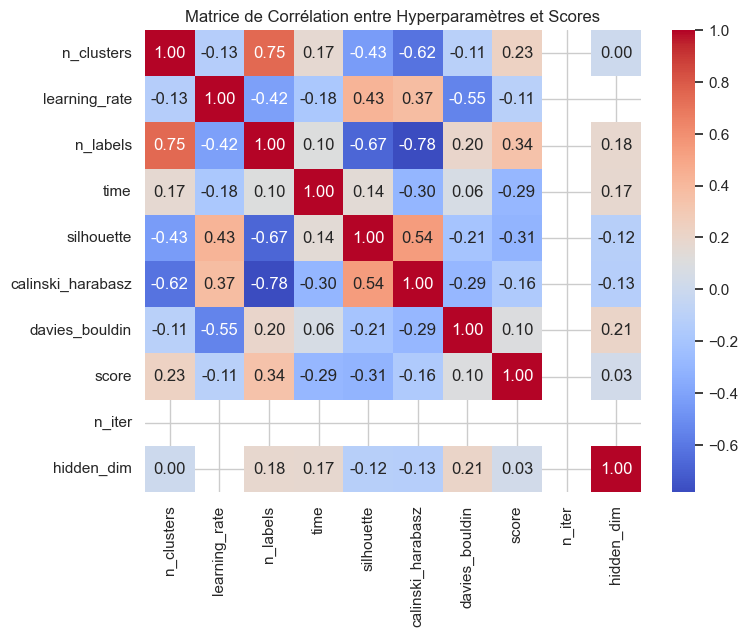

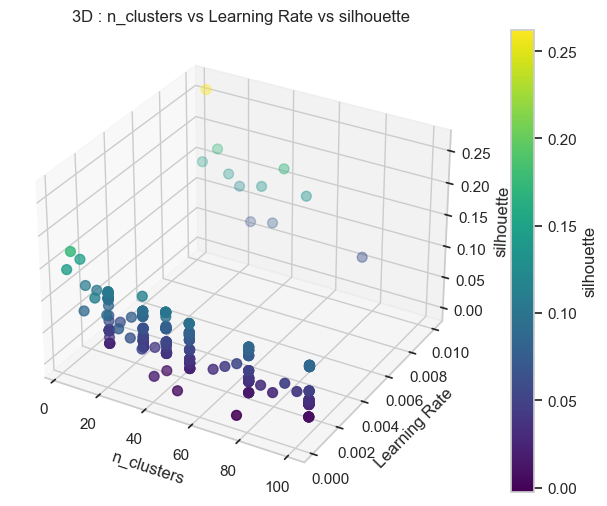

C:\Users\racim\AppData\Local\Temp\ipykernel_21684\347191385.py:31: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(x="n_clusters", y=metric, data=df[df["kernel"] != "sigmoid"],


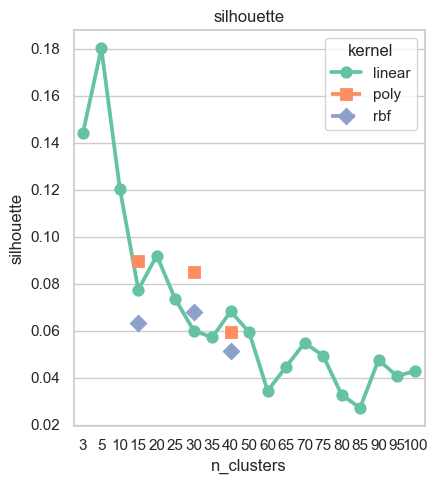

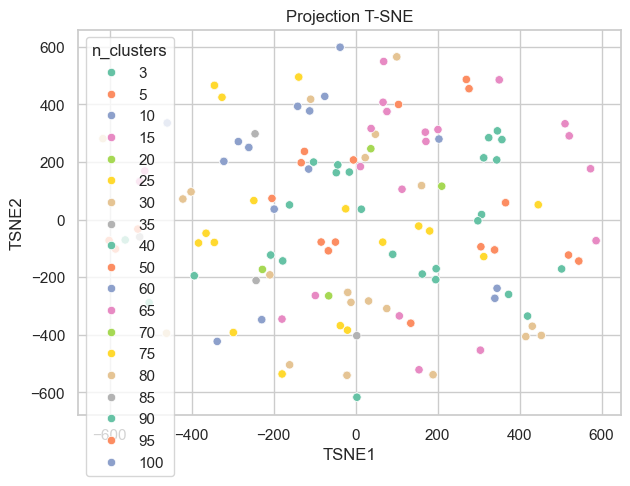

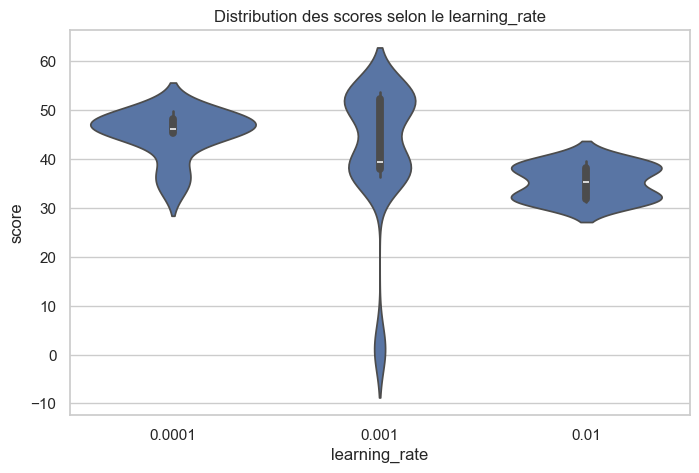

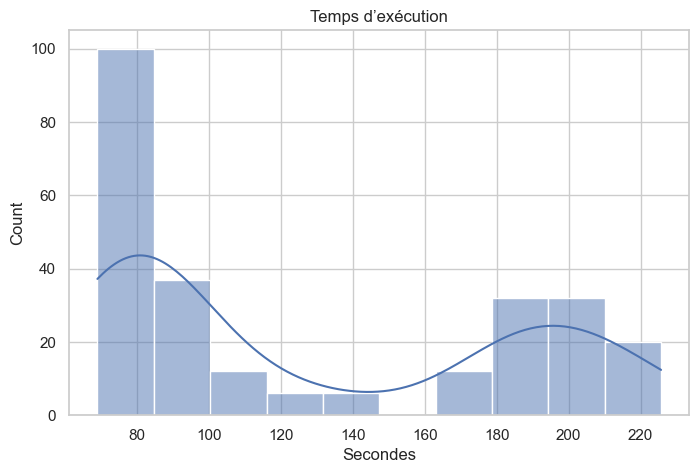

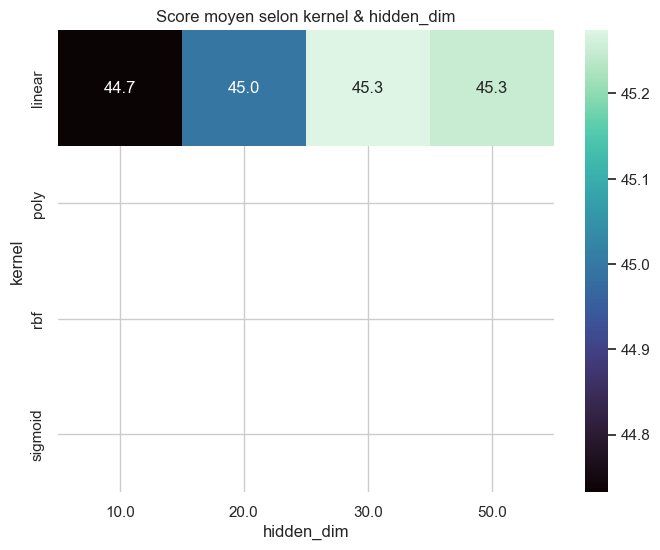

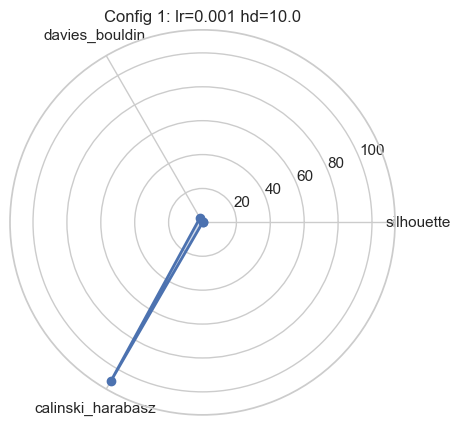

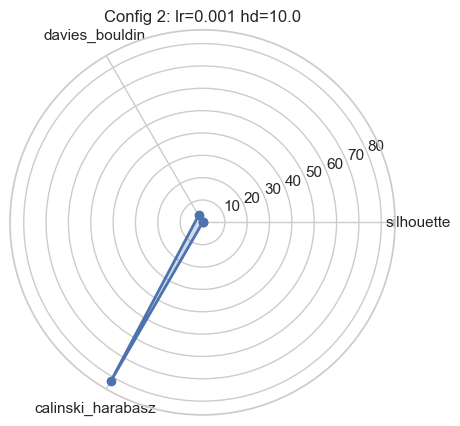

In [9]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# --- S√©lection des seules colonnes num√©riques pour la corr√©lation ---
num_df = df.select_dtypes(include=[np.number])

# 1Ô∏è‚É£ Matrice de corr√©lation (uniquement num√©rique)
plt.figure(figsize=(8, 6))
sns.heatmap(num_df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matrice de Corr√©lation entre Hyperparam√®tres et Scores")
plt.show()

# 2Ô∏è‚É£ Graphique 3D des interactions
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(df["n_clusters"], df["learning_rate"], df["silhouette"],
                c=df["silhouette"], cmap="viridis", s=50)
ax.set_xlabel("n_clusters")
ax.set_ylabel("Learning Rate")
ax.set_zlabel("silhouette")
plt.colorbar(sc, label="silhouette")
plt.title("3D : n_clusters vs Learning Rate vs silhouette")
plt.show()



plt.figure(figsize=(12, 5))
for i, metric in enumerate(["silhouette"], 1):
    plt.subplot(1, 3, i)
    sns.pointplot(x="n_clusters", y=metric, data=df[df["kernel"] != "sigmoid"],
                 markers=["o", "s", "D"], linestyles=["-", "--", "-."],
                 palette="Set2", ci=None, hue="kernel")
    plt.title(metric)
plt.tight_layout()
plt.show()



# 6Ô∏è‚É£ T-SNE non-lin√©aire
# Utiliser uniquement les colonnes num√©riques pour T-SNE
tsne = TSNE(n_components=2, perplexity=5, learning_rate=100, random_state=42)
# On prend les colonnes num√©riques pertinentes
tsne_cols = ["learning_rate", "silhouette"]
coords2 = tsne.fit_transform(num_df[tsne_cols].values)
df_tsne = pd.DataFrame(coords2, columns=["TSNE1", "TSNE2"])
plt.figure(figsize=(7, 5))
sns.scatterplot(x="TSNE1", y="TSNE2", hue=df["n_clusters"], palette="Set2", data=df_tsne)
plt.title("Projection T-SNE")
plt.show()

# 7Ô∏è‚É£ Violinplot du score par learning_rate
plt.figure(figsize=(8, 5))
sns.violinplot(x="learning_rate", y="score", data=df)
plt.title("Distribution des scores selon le learning_rate")
plt.show()

# 8Ô∏è‚É£ Histogramme des temps d‚Äôex√©cution
plt.figure(figsize=(8, 5))
sns.histplot(df["time"], bins=10, kde=True)
plt.title("Temps d‚Äôex√©cution")
plt.xlabel("Secondes")
plt.show()

# 9Ô∏è‚É£ Heatmap Score vs (hidden_dim, n_clusters)
pivot = df.pivot_table(index="kernel",
                       columns="hidden_dim",
                       values="score",
                       aggfunc="mean")

# Fill missing values with np.nan (or 0 if you prefer)
pivot = pivot.reindex(index=['linear', 'poly', 'rbf', 'sigmoid'])  # Ensure all kernels are present
plt.figure(figsize=(8, 6))
sns.heatmap(pivot, annot=True, fmt=".1f", cmap="mako")
plt.title("Score moyen selon kernel & hidden_dim")
plt.show()

# üîü Radar chart de quelques configurations cl√©s
import math
def radar_plot(row, metrics, title):
    angles = np.linspace(0, 2*math.pi, len(metrics), endpoint=False).tolist()
    values = row[metrics].tolist()
    values += values[:1]  # boucle la forme
    angles += angles[:1]
    fig, ax = plt.subplots(subplot_kw=dict(polar=True), figsize=(5,5))
    ax.plot(angles, values, 'o-', linewidth=2)
    ax.fill(angles, values, alpha=0.25)
    ax.set_thetagrids(np.degrees(angles[:-1]), metrics)
    ax.set_title(title)
    plt.show()

metrics = ["silhouette","davies_bouldin","calinski_harabasz"]
# Exemple sur les deux premi√®res configs
radar_plot(df.iloc[0], metrics, f"Config 1: lr={df.iloc[0]['learning_rate']} hd={df.iloc[0]['hidden_dim']}")
radar_plot(df.iloc[1], metrics, f"Config 2: lr={df.iloc[1]['learning_rate']} hd={df.iloc[1]['hidden_dim']}")

### Fonction pour tracer un diagramme de Sankey
Permet de visualiser le flux d'√©tiquettes entre deux classifications diff√©rentes.

In [ ]:
def plot_sankey(labels_old, labels_new, title="Sankey: ancienne vs nouvelle classification"):
    # V√©rifier la taille
    assert len(labels_old) == len(labels_new), "Les deux vecteurs doivent avoir la m√™me taille"

    # Encoder pour avoir des entiers cons√©cutifs
    le_old = LabelEncoder().fit(labels_old)  # [1,2,...,1079] 
    le_new = LabelEncoder().fit(labels_new)
    old_encoded = le_old.transform(labels_old)
    new_encoded = le_new.transform(labels_new)

    # Cr√©er un DataFrame crois√©
    df = pd.DataFrame({"old": old_encoded, "new": new_encoded})
    flow = df.groupby(["old", "new"]).size().reset_index(name='count')

    # Cr√©er les labels pour le sankey
    old_labels = [f"Old {cls}" for cls in le_old.classes_]
    new_labels = [f"New {cls}" for cls in le_new.classes_]
    labels = old_labels + new_labels

    # Mapper les index
    flow['source'] = flow['old']
    flow['target'] = flow['new'] + len(le_old.classes_)

    # Sankey diagram
    fig = go.Figure(data=[go.Sankey(
        node=dict(
            pad=15,
            thickness=20,
            line=dict(color="black", width=0.5),
            label=labels
        ),
        link=dict(
            source=flow['source'],
            target=flow['target'],
            value=flow['count']
        )
    )])

    fig.update_layout(title_text=title, font_size=12)
    fig.show()

### Chargement de deux classifications √† comparer (pour Sankey)
On pr√©pare la comparaison visuelle des clusters trouv√©s par diff√©rentes m√©thodes.

In [38]:
classification_old = pd.read_csv("../DATA/classification_results_K22_AjB_NGC1068_K16_class15_deredshifted_30.csv").to_numpy()
print("Classification ancienne charg√©e :", classification_old.shape)

classification_new = classification_old.copy()

plot_sankey(classification_old[1], classification_new[1], title="Sankey Diagram")

Classification ancienne charg√©e : (1078, 2)


### (Bis) Agr√©gation de r√©sultats sur plusieurs fichiers
Comme pr√©c√©demment, analyse de lots de r√©sultats de clustering pour √©tude de stabilit√© ou de performances.

In [17]:
import os
import json
import glob
import pandas as pd

# üìÅ Dossier contenant les r√©sultats
folder_path = "./../results/json/st/complet"  
#folder_path_complet = "./../results/json/st/complet"
# üîç Trouve tous les fichiers .json et .jsonl
json_files = glob.glob(os.path.join(folder_path, "*.json"))
jsonl_files = glob.glob(os.path.join(folder_path, "*.jsonl"))
# üì¶ Liste de tous les r√©sultats
results = []

# üì• Lecture des fichiers .jsonl (une ligne = un dict)
for file_path in jsonl_files:
    print(f"üìÇ Chargement JSONL : {file_path}")
    with open(file_path, "r") as f:
        for line in f:
            try:
                results.append(json.loads(line))
            except json.JSONDecodeError as e:
                print(f"‚ö†Ô∏è Erreur JSONL dans {file_path} : {e}")

# üì• Lecture des fichiers .json (fichier entier = list ou dict)
for file_path in json_files:
    print(f"üìÇ Chargement JSON : {file_path}")
    with open(file_path, "r") as f:
        try:
            data = json.load(f)
            # Si c‚Äôest une liste de dicts, on √©tend
            if isinstance(data, list):
                results.extend(data)
            else:
                results.append(data)
        except json.JSONDecodeError as e:
            print(f"‚ö†Ô∏è Erreur JSON dans {file_path} : {e}")

# ‚úÖ Conversion en DataFrame
df = pd.DataFrame(results)
print(f"\n‚úÖ {len(results)} r√©sultats charg√©s depuis {len(json_files) } fichiers.")

# Aper√ßu des colonnes
print("üìä Colonnes disponibles :", df.columns.tolist())

 
 

üìÇ Chargement JSONL : ./../results/json/st/complet\linear_20_-3.jsonl
üìÇ Chargement JSONL : ./../results/json/st/complet\poly_20_-3.jsonl

‚úÖ 2 r√©sultats charg√©s depuis 0 fichiers.
üìä Colonnes disponibles : ['sample_size', 'kernel', 'n_clusters', 'n_labels', 'time', 'silhouette', 'calinski_harabasz', 'davies_bouldin', 'learning_rate', 'score', 'n_iter', 'hidden_dim', 'ov']


### Visualisation‚ÄØ: courbes de scores selon le nombre de clusters et le kernel
Pr√©paration des graphes pour analyser les tendances selon les hyperparam√®tres.

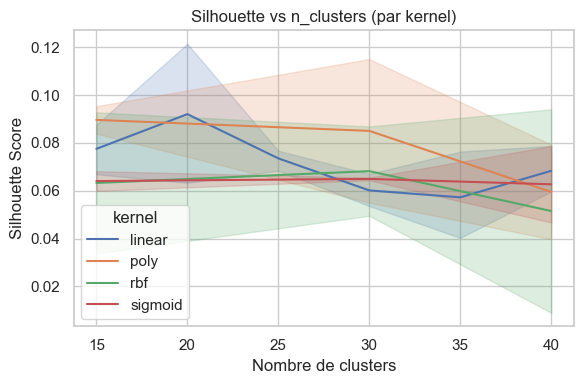

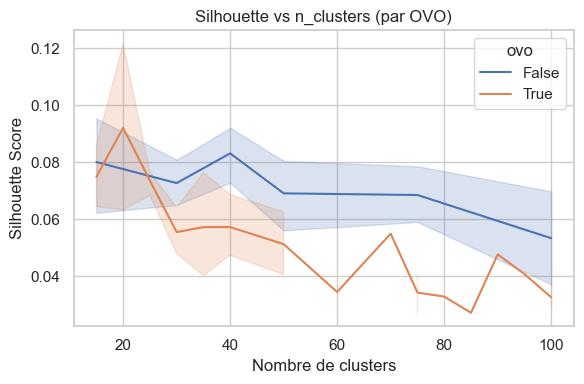

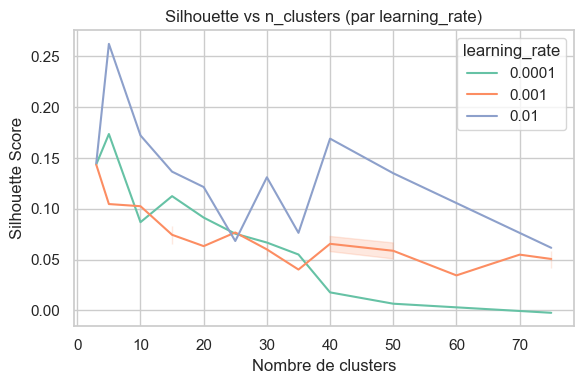

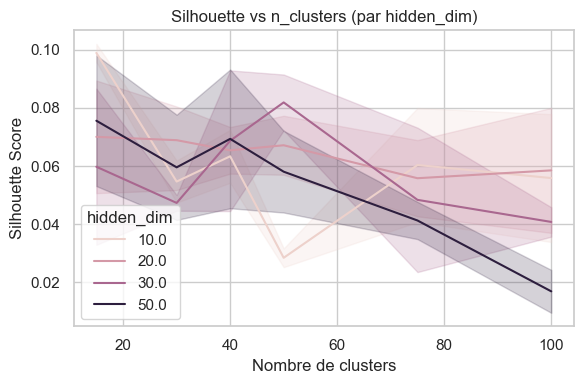

In [ ]:
sns.set_theme(style="whitegrid")

# -------- Courbe 1 : n_clusters vs silhouette selon kernel --------
plt.figure(figsize=(6, 4))
sns.lineplot(
    data=df[(df["n_clusters"] >= 15) & (df["n_clusters"] <= 40)],
    x="n_clusters",
    y="silhouette",
    hue="kernel"
)
plt.title("Silhouette vs n_clusters (par kernel)")
plt.xlabel("Nombre de clusters")
plt.ylabel("Silhouette Score")
plt.tight_layout()
plt.show()

# -------- Courbe 2 : n_clusters vs silhouette selon ovo --------
plt.figure(figsize=(6, 4))
sns.lineplot(data=df[df["n_clusters"] >= 15], x="n_clusters", y="silhouette", hue="ovo")
plt.title("Silhouette vs n_clusters (par OVO)")
plt.xlabel("Nombre de clusters")
plt.ylabel("Silhouette Score")
plt.tight_layout()
plt.show()

# -------- Courbe 3 : n_clusters vs silhouette selon learning_rate --------
plt.figure(figsize=(6, 4))
sns.lineplot(data=df[df["n_clusters"] <= 75], x="n_clusters", y="silhouette", hue="learning_rate", palette="Set2")
plt.title("Silhouette vs n_clusters (par learning_rate)")
plt.xlabel("Nombre de clusters")
plt.ylabel("Silhouette Score")
plt.xscale("linear")  # ou log si besoin
plt.tight_layout()
plt.show()

# -------- Courbe 4 : n_clusters vs silhouette selon hidden_dim --------
if "hidden_dim" in df.columns:
    plt.figure(figsize=(6, 4))
    sns.lineplot(data=df, x="n_clusters", y="silhouette", hue="hidden_dim")
    plt.title("Silhouette vs n_clusters (par hidden_dim)")
    plt.xlabel("Nombre de clusters")
    plt.ylabel("Silhouette Score")
    plt.tight_layout()
    plt.show()
else:
    print("‚ùå Colonne 'hidden_dim' non trouv√©e dans le DataFrame.")


### (Bis) Parcours d'un dossier pour agr√©ger les r√©sultats
Reprise de l'agr√©gation des fichiers de r√©sultats pour une analyse group√©e.

In [28]:

# üìÅ Dossier contenant les r√©sultats
folder_path = "./../results/json/st"  
folder_path_complet = "./../results/json/st/complet"
# üîç Trouve tous les fichiers .json et .jsonl
json_files = glob.glob(os.path.join(folder_path, "*.json"))
jsonl_files = glob.glob(os.path.join(folder_path, "*.jsonl"))
jsonl_files += glob.glob(os.path.join(folder_path_complet, "*.jsonl"))
# üì¶ Liste de tous les r√©sultats
results = []

# üì• Lecture des fichiers .jsonl (une ligne = un dict)
for file_path in jsonl_files:
    print(f"üìÇ Chargement JSONL : {file_path}")
    with open(file_path, "r") as f:
        for line in f:
            try:
                results.append(json.loads(line))
            except json.JSONDecodeError as e:
                print(f"‚ö†Ô∏è Erreur JSONL dans {file_path} : {e}")

# üì• Lecture des fichiers .json (fichier entier = list ou dict)
for file_path in json_files:
    print(f"üìÇ Chargement JSON : {file_path}")
    with open(file_path, "r") as f:
        try:
            data = json.load(f)
            # Si c‚Äôest une liste de dicts, on √©tend
            if isinstance(data, list):
                results.extend(data)
            else:
                results.append(data)
        except json.JSONDecodeError as e:
            print(f"‚ö†Ô∏è Erreur JSON dans {file_path} : {e}")

# ‚úÖ Conversion en DataFrame
df = pd.DataFrame(results)
print(f"\n‚úÖ {len(results)} r√©sultats charg√©s depuis {len(json_files) } fichiers.")

# Aper√ßu des colonnes
print("üìä Colonnes disponibles :", df.columns.tolist())
# Filtrer les donn√©es pour n_clusters=30
data = [entry for entry in results if entry['n_clusters'] == 30 and entry['n_labels'] > 5]
print("Nombre de configurations pour n_clusters=30 :", len(data))
# Extraire le silhouette maximum pour n_clusters=30
silhouette_max = max(data, key=lambda x: x['silhouette'])
print("Silhouette maximum :", silhouette_max['silhouette'])
print("Configuration avec silhouette maximum :", silhouette_max)



üìÇ Chargement JSONL : ./../results/json/st\ovo_hid.jsonl
üìÇ Chargement JSONL : ./../results/json/st\rapport.jsonl
üìÇ Chargement JSONL : ./../results/json/st/complet\linear_20_-3.jsonl
üìÇ Chargement JSONL : ./../results/json/st/complet\poly_20_-3.jsonl
üìÇ Chargement JSON : ./../results/json/st\diff_kernel_re_standardise.json
üìÇ Chargement JSON : ./../results/json/st\finale_re_standardise.json

‚úÖ 163 r√©sultats charg√©s depuis 2 fichiers.
üìä Colonnes disponibles : ['kernel', 'n_clusters', 'learning_rate', 'n_labels', 'time', 'silhouette', 'calinski_harabasz', 'davies_bouldin', 'score', 'n_iter', 'ovo', 'hidden_dim', 'sample_size', 'ov']
Nombre de configurations pour n_clusters=30 : 28
Silhouette maximum : 0.1151
Configuration avec silhouette maximum : {'kernel': 'poly', 'n_clusters': 30, 'learning_rate': 0.001, 'n_labels': 13, 'time': 131.93, 'silhouette': 0.1151, 'calinski_harabasz': 102.9375, 'davies_bouldin': 2.8418, 'score': 2.0925, 'n_iter': 1000, 'ovo': True}
